<a href="https://colab.research.google.com/github/Foglia-m/IA/blob/main/My_RL_TP_v3_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

This lab is about using DRL to solve the CartPole problem (cotinuous input, discrete actions) using methods inspired by DQN.

We will be using the OpenAI gym library to simulate our environment and a custom implementation of an agent to demonstrate the different building blocks of a DRL agent. This colab is destined for demonstration purposes only, using a framework (like ACME) is advised for any sophisticated use of DRL.

# 2. Imports

In [1]:
import gym
import torch # PyTorch
import numpy as np
import random
import copy

env = gym.make("CartPole-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 3. [Class] QNetwork

In [31]:
""" Define class AgentNeuralNetwork """

class QNetwork(torch.nn.Module):
    def __init__(self, stateSpace, actionSpace, width=128, dropoutRate=0.5):
        super(QNetwork, self).__init__()
        inputLength = self._stateSpace_to_input(stateSpace) # Reading input size from environment's state space
        nbActions = self._actionSpace_to_output(actionSpace) # Reading number of actions from environment's action space

        self.activation = torch.nn.Sigmoid()
        # self.activation = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(dropoutRate)

        self.inputLayer = torch.nn.Linear(inputLength, width)
        self.hiddenLayer1 = torch.nn.Linear(width, width*2)
        self.hiddenLayer2 = torch.nn.Linear(width*2, width*4)
        self.hiddenLayer3 = torch.nn.Linear(width*4, width*2)
        self.hiddenLayer4 = torch.nn.Linear(width*2, width)

        self.outputLayers = torch.nn.ModuleList([])
        for depth in range(0, nbActions, 1): # One output per action
            self.outputLayers.append(torch.nn.Linear(width, 1))

    def _stateSpace_to_input(self, stateSpace):
        assert isinstance(stateSpace, gym.spaces.box.Box), "[Error] Type of <stateSpace> is not handled by the neural network."
        return stateSpace.shape[0]

    def _actionSpace_to_output(self, actionSpace):
        assert isinstance(actionSpace, gym.spaces.discrete.Discrete), "[Error] Type of <actionSpace> is not handled by the neural network."
        return actionSpace.n

    def forward(self, x):
        """ Implementation of the forward pass of the qNetwork """

        x = self.dropout(self.activation(self.inputLayer(x)))
        x = self.dropout(self.activation(self.hiddenLayer1(x)))
        x = self.dropout(self.activation(self.hiddenLayer2(x)))
        x = self.dropout(self.activation(self.hiddenLayer3(x)))
        x = self.activation(self.hiddenLayer4(x))

        outputs = [outputLayer(x) for outputLayer in self.outputLayers] # List of <nbActions> elements containing the <nbState> scores of that action
        outputs = torch.stack(outputs) # [<nbActions>, <nbStates>, 1]
        outputs = torch.squeeze(outputs, 2) # [<nbActions>, <nbStates>, 1] -> [<nbActions>, <nbStates>]
        outputs = outputs.permute(1, 0) # [<nbActions>, <nbStates>] -> [<nbStates>, <nbActions>]
        return outputs

    def Q(self, S, A=None, verbose=False):
      """ Other inference function to allow A to be specified or not.
      If A is specified, the specific value is returned. If not, all values are returned. """
      # <S> := [list] of states
      # <A> := [list] of actions
      S = torch.Tensor(S) # Python list -> PyTorch tensor
      if verbose : print("\n\n\nS : ", S)
      Q_S = self.forward(S)
      if verbose : print("Q_S : ", Q_S)
      if (A == None): return Q_S # Return the Q value of all possible actions
      if verbose : print("A : ", A)
      Q_S_A = [q[a] for (q, a) in zip(Q_S, A)] # Select the exact Q-values of actions A
      if verbose : print("Q_S_A : ", Q_S_A)
      Q_S_A = torch.stack(Q_S_A)
      if verbose : print("Q_S_A : ", Q_S_A)
      return Q_S_A # Return the Q value of a specific action



In [3]:
""" Test class AgentNeuralNetwork """

model = QNetwork(env.observation_space, env.action_space)
print(model)
mockInput = torch.rand(10, 4)
results = model(mockInput)
print(f"results\t: {results}")


QNetwork(
  (activation): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (inputLayer): Linear(in_features=4, out_features=64, bias=True)
  (hiddenLayer1): Linear(in_features=64, out_features=128, bias=True)
  (hiddenLayer2): Linear(in_features=128, out_features=256, bias=True)
  (hiddenLayer3): Linear(in_features=256, out_features=128, bias=True)
  (hiddenLayer4): Linear(in_features=128, out_features=64, bias=True)
  (outputLayers): ModuleList(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)
results	: tensor([[ 0.3241, -0.1825],
        [ 0.2795, -0.1629],
        [ 0.3021, -0.1491],
        [ 0.2498, -0.2195],
        [ 0.3348, -0.2267],
        [ 0.3443, -0.2204],
        [ 0.3194, -0.2692],
        [ 0.3428, -0.1314],
        [ 0.3058, -0.2187],
        [ 0.2643, -0.1601]], grad_fn=<PermuteBackward>)


# 4. [Class] Doer

In [7]:
""" Define Class Doer """

class Doer():
  def __init__(self, model, stateSpace, actionSpace, epsilon=0.1):
    self.stateSpace = stateSpace
    self.actionSpace = actionSpace
    self.qNetwork = model
    self.epsilon = epsilon

  def act(self, state, verbose=False):
    assert isinstance(state, np.ndarray), "[Error] Type of <state> is not handled by the doer."
    if (random.random() < self.epsilon):
      if (verbose) : print("Epsilon-Greedy => Random action")
      return env.action_space.sample()
    self.qNetwork.eval()
    qValues = self.qNetwork.Q([state])[0]
    qValues = [float(qValues[0]), float(qValues[1])]
    if (verbose) : print(f"qValues : {qValues}")
    action = qValues.index(max(qValues))
    if (verbose) : print(f"action : {action}")
    return action

class Doer_Random():
  def __init__(self, *args, **kwargs) :
    self.epsilon = 0
  def act(self, state):
    return env.action_space.sample()

In [8]:
""" Test class Doer """

model = QNetwork(env.observation_space, env.action_space)
doer = Doer(model, env.observation_space, env.action_space)
state = env.reset()
action = doer.act(state, verbose=True)

qValues : [-0.2774849534034729, -0.473802387714386]
action : 0


# 5. [Class] Experience Replay

In [10]:
""" Define class Transition """

class Transition():
  # A transition is a list of [St, At, Rt, St+1, At+1]
  def __init__(self, St, At, Rt, Stp, Atp, isTerminal=False, ID=None, relevance=None, birthdate=-1):
    self.St = St
    self.At = At
    self.Rt = Rt
    self.Stp = Stp
    self.Atp = Atp
    self.isTerminal = isTerminal
    self.ID = ID
    self.relevance = relevance
    self.birthdate = birthdate

  def isValid(self):
    if (
        (self.St is None)
        or (self.At is None)
        or (self.Rt is None)
        or (self.Stp is None)
        or (self.Atp is None)
    ): return False
    return True 

  def __str__(self):
    # return f"Transition SARSA :\n\tSt   : {self.St}\n\tAt   : {self.At}\n\tRt   : {self.Rt}\n\tSt+1 : {self.Stp}\n\tAt+1 : {self.Atp}\n\tisTerminal : {self.isTerminal}\n\tID : {self.ID}\n\trelevance : {self.relevance}"
    return f"[Transition] St: {self.St} | At: {self.At} | Rt: {self.Rt} | St+1: {self.Stp} | At+1: {self.Atp} | isTerminal: {self.isTerminal} | ID: {self.ID} | relevance: {self.relevance} | birthdate: {self.birthdate}"


In [11]:
""" Test class Transition """

St = np.random.random(5)
At = None
Rt = random.random()
Stp = np.random.random(5)
Atp = 1
transition = Transition(St, At, Rt, Stp, Atp)
print(transition)

[Transition] St: [0.73448459 0.3948011  0.48994627 0.87763562 0.54040704] | At: None | Rt: 0.10029900393626556 | St+1: [0.93141084 0.68616775 0.69149702 0.79899137 0.42958499] | At+1: 1 | isTerminal: False | ID: None | relevance: None | birthdate: -1


In [12]:

class ExperienceReplay():
  def __init__(self, bufferSize=1000, batchSize=256, weightedBatches=True, sortTransition=False):
    self.transitions = []
    self.bufferSize = bufferSize
    self.IDnumber = 0
    self.batchSize = batchSize
    self.weightedBatches=True
    self.sortTransition = sortTransition

  def addTransition(self, transition) :
    if (len(self.transitions) > self.bufferSize): self._removeTransition(1)
    self.transitions.append(transition)
    if (self.sortTransition) : self.transitions.sort(key=lambda t:t.relevance if (t.relevance is not None) else 42)

  def _removeTransition(self, n) :
    self.transitions.pop(0)

  def sampleBatch(self) :
    if (len(self.transitions) == 0): return []
    if not(self.weightedBatches) :
      batch = random.choices(self.transitions, k=min(self.batchSize, len(self.transitions)))
      batch = list(set(batch))
      return batch
    else :
      weights = [transition.relevance for transition in self.transitions]
      nonNoneWeights = [weight for weight in weights if (weight is not None)]
      if (len(nonNoneWeights) == 0): maxWeight = 1
      else : maxWeight = max(nonNoneWeights)
      weights = [weight if (weight is not None) else maxWeight for weight in weights]
      batch = random.choices(self.transitions, k=min(self.batchSize, len(self.transitions)), weights=weights)
      batch = list(set(batch))
      return batch

  def flush(self):
    self.transitions = []

In [14]:
ER = ExperienceReplay(batchSize=3)
for _ in range(10):
  rand = random.random()
  if random.random() < 0.7 :
    newT = Transition(None, None, None, None, None, relevance=rand*rand*rand)
  else :
    newT = Transition(None, None, None, None, None, relevance=None)
  ER.addTransition(newT)

for t in ER.transitions :
  print("\t rel : ", t.relevance)

batch = ER.sampleBatch()

print("\nbatch")
for t in batch :
  print("\t rel : ", t.relevance)



	 rel :  0.8801347850580818
	 rel :  None
	 rel :  None
	 rel :  0.6442655830119488
	 rel :  0.6691663575569339
	 rel :  None
	 rel :  None
	 rel :  None
	 rel :  None
	 rel :  None

batch
	 rel :  0.6691663575569339
	 rel :  0.6442655830119488
	 rel :  None


# 6. [Class] Learner

In [17]:
""" Define class Learner """

class Learner():
  def __init__(self, qNetwork, stateSpace, actionSpace, gamma=1, algorithm="SARSA"):
    self.stateSpace = stateSpace
    self.actionSpace = actionSpace

    self.qNetwork_target = qNetwork
    self.qNetwork_target.train()

    self.qNetwork_targetFrozen = copy.deepcopy(self.qNetwork_target)
    self.qNetwork_targetFrozen.eval()

    self.gamma = gamma
    self.algorithm=algorithm
    # self.optimizer = torch.optim.SGD(self.qNetwork.parameters(), lr=0.001, momentum=0.99)
    self.optimizer = torch.optim.Adam(self.qNetwork_target.parameters())

  def _cleanBatch(self, batch):
    """ Remove all unusable transitions """
    validityList = [transition.isValid() for transition in batch]
    popIndices = [index for (index, valid) in enumerate(validityList) if valid == False]
    for popIndex in popIndices[::-1]: batch.pop(popIndex) # Pop transitions from end to start to keep validity of other indices
    return batch

  def _computeTarget(self, Stp, Atp, Rt, areTerminal, verbose=False):
    if verbose : print(f"Algorithm : {self.algorithm}")
    if (self.algorithm == "SARSA") : # SARSA
      self.qNetwork_targetFrozen.eval()
      target = self.qNetwork_targetFrozen.Q(Stp, Atp)
      if (verbose) : print("Qf_Stp_Atp : ", target)
    elif (self.algorithm == "QLEARNING") : # Q-learning
      self.qNetwork_targetFrozen.eval()
      Q_Stp = self.qNetwork_targetFrozen.Q(Stp)
      if verbose : print(f"Qf_Stp : {Q_Stp}")
      target = torch.max(Q_Stp, dim=1)[0]
    target = torch.stack([t.detach() for t in target]) # Detach the gradient -> Semi-gradient methods
    target = [float(elt) for elt in target]    
    target = torch.tensor(target)
    Rt = torch.as_tensor(Rt)
    if verbose : print(f"gamma : {self.gamma}")
    target = Rt + self.gamma * target
    target = torch.stack([t if not(isTerminal) else torch.as_tensor(0) for (t, isTerminal) in zip(target, areTerminal)]) # Force value of terminal transtion at 0
    # target = torch.stack([t if not(isTerminal) else torch.as_tensor(-1) for (t, isTerminal) in zip(target, areTerminal)]) # Force value of terminal transtion at 0
    return target

  def learn(self, batch, verbose=False):
    """ Learns from <batch> using algo "SARSA" or "QLEARNING"

    SARSA : Q(St, At) <- Q(St, At) + alpha * [Rt+1 + gamma * Q(St+1, At+1) - Q(St, At)]

    Q-Learning : Q(St, At) <- Q(St, At) + alpha * [Rt+1 + gamma * max(Q(St+1, a)) - Q(St, At)] """

    # <batch> is a [list] of transitions. A transition contains (St, At, Rt, St+1, At+1)
    assert isinstance(batch, list), "[Error] Type of <batch> is not handled by the learner."
    for element in batch :
      assert isinstance(element, Transition), "[Error] Element of <batch> is not a Transition"

    batch = self._cleanBatch(batch)
    if (len(batch) == 0) :
      print("Empty batch")
      return -1
    if verbose : print(f"batch : {batch}")

    St = [transition.St for transition in batch]
    At = [transition.At for transition in batch]
    Rt = [transition.Rt for transition in batch]
    Stp = [transition.Stp for transition in batch]
    Atp = [transition.Atp for transition in batch]
    areTerminal = [transition.isTerminal for transition in batch]

    if verbose : print(f"\tSt : {St}\n\tAt : {At}\n\tRt : {Rt}\n\tStp : {Stp}\n\tAtp : {Atp}\n\tterminal : {areTerminal}")

      # Compute Q(St, At) and Q(St+1, At+1)
    self.qNetwork_target.train()
    Q_St_At = self.qNetwork_target.Q(St, At, verbose=False)
    if (verbose) : print("Q_St_At : ", Q_St_At)

    target = self._computeTarget(Stp, Atp, Rt, areTerminal, verbose=verbose)
    if verbose : print(f"target : {target}")

      # Computing errors
    errors = torch.square(target - Q_St_At)
    if (verbose) : print(f"errors : {errors}")
    loss = torch.sum(errors) / errors.size()[0]
    if (verbose) : print(f"loss : {loss}")
    self.optimizer.zero_grad()
    loss.backward()
    stepVal = self.optimizer.step()

    relevances = [x.item() for x in errors]
    for transition, relevance in zip(batch, relevances) :
      transition.relevance = relevance

    return loss.item()

  def updateFrozenTarget(self):
    self.qNetwork_targetFrozen = copy.deepcopy(self.qNetwork_target)
    self.qNetwork_targetFrozen.eval()


In [16]:
""" Prepare the visualization of the training """

model = QNetwork(env.observation_space, env.action_space)
doer = Doer(model, env.observation_space, env.action_space, epsilon=0.20)
learner = Learner(model, env.observation_space, env.action_space, gamma=0.9)
ER = ExperienceReplay()

state_0 = env.reset()
action_0 = None

action_1 = doer.act(state_0)
state_1, reward_1, terminal_1, info = env.step(action_1)

transition_0 = Transition(state_0, action_0, reward_1, state_1, action_1, isTerminal=terminal_1)
ER.addTransition(transition_0)

action_2 = doer.act(state_1)
state_2, reward_2, terminal_2, info = env.step(action_2)

transition_1 = Transition(state_1, action_1, reward_2, state_2, action_2, isTerminal=terminal_2)
ER.addTransition(transition_1)

batch = [transition_0, transition_1]

In [18]:
""" Show the target and targetFrozen networks used by the learner are different after training """

print("Before train :")
learner.qNetwork_target.eval()
print(f"\t{learner.qNetwork_target.Q([state_1], [action_1])}")
learner.qNetwork_targetFrozen.eval()
print(f"\t{learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")

loss = learner.learn(batch, verbose=True)

print("After train :")
learner.qNetwork_target.eval()
print(f"\t{learner.qNetwork_target.Q([state_1], [action_1])}")
learner.qNetwork_target.train()
print(f"\t{learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")

# Their difference increase the more we train on the same batch
for _ in range(10):
  print(f"\nStep {_}, loss = {loss}")
  learner.qNetwork_target.eval()
  print(f"\tTarget : {learner.qNetwork_target.Q([state_1], [action_1])}")
  learner.qNetwork_target.train()
  print(f"\tFrozen : {learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")
  doer.qNetwork.eval()
  print(f"\tDoer : {doer.qNetwork.Q([state_1], [action_1])}")

  loss = learner.learn(batch, verbose=False)

# Eventually, the learned balue corresponds to the target
for _ in range(100):
  loss = learner.learn(batch, verbose=False)

print(f"\nStep n, loss : {loss}")
learner.qNetwork_target.eval()
print(f"\t{learner.qNetwork_target.Q([state_1], [action_1])}")
learner.qNetwork_target.train()
print(f"\t{learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")

loss = learner.learn(batch, verbose=True)

Before train :
	tensor([0.4175], grad_fn=<StackBackward>)
	tensor([0.4175], grad_fn=<StackBackward>)
batch : [<__main__.Transition object at 0x7fa8204f5cf8>]
	St : [array([-0.03513205,  0.23585893, -0.0050569 , -0.29628787])]
	At : [1]
	Rt : [1.0]
	Stp : [array([-0.03041487,  0.04080943, -0.01098265, -0.00520409])]
	Atp : [0]
	terminal : [False]
Q_St_At :  tensor([0.3693], grad_fn=<StackBackward>)
Algorithm : SARSA
Qf_Stp_Atp :  tensor([-0.0621], grad_fn=<StackBackward>)
gamma : 0.9
target : tensor([0.9441])
errors : tensor([0.3303], grad_fn=<PowBackward0>)
loss : 0.330344021320343
After train :
	tensor([0.4869], grad_fn=<StackBackward>)
	tensor([0.4175], grad_fn=<StackBackward>)

Step 0, loss = 0.330344021320343
	Target : tensor([0.4869], grad_fn=<StackBackward>)
	Frozen : tensor([0.4175], grad_fn=<StackBackward>)
	Doer : tensor([0.4869], grad_fn=<StackBackward>)

Step 1, loss = 0.2832857370376587
	Target : tensor([0.5658], grad_fn=<StackBackward>)
	Frozen : tensor([0.4175], grad_fn=<

In [19]:
""" Show the frozen network catches up with the target when weights are shared again """

print("Before catching up :")
learner.qNetwork_target.eval()
print(f"\tLearner (qNetwork) : {learner.qNetwork_target.Q([state_1], [action_1])}")
learner.qNetwork_target.train()
print(f"\tLearner (Frozen) : {learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")
doer.qNetwork.eval()
print(f"\tDoer : {doer.qNetwork.Q([state_1], [action_1])}")

learner.updateFrozenTarget()

print("After catching up :")
learner.qNetwork_target.eval()
print(f"\tLearner (qNetwork) : {learner.qNetwork_target.Q([state_1], [action_1])}")
learner.qNetwork_target.train()
print(f"\tLearnerFrozen : {learner.qNetwork_targetFrozen.Q([state_1], [action_1])}")
doer.qNetwork.eval()
print(f"\tDoer : {doer.qNetwork.Q([state_1], [action_1])}")



Before catching up :
	Learner (qNetwork) : tensor([0.9248], grad_fn=<StackBackward>)
	Learner (Frozen) : tensor([0.4175], grad_fn=<StackBackward>)
	Doer : tensor([0.9248], grad_fn=<StackBackward>)
After catching up :
	Learner (qNetwork) : tensor([0.9248], grad_fn=<StackBackward>)
	LearnerFrozen : tensor([0.9248], grad_fn=<StackBackward>)
	Doer : tensor([0.9248], grad_fn=<StackBackward>)


# 7. Training Loop

In [52]:
""" Initialise training """

qNetwork = QNetwork(env.observation_space, env.action_space, width=256, dropoutRate=0.2)
doer = Doer(qNetwork, env.observation_space, env.action_space, epsilon=0.3)
# doer = Doer_Random(model, env.observation_space, env.action_space, epsilon=1) # Random agent. How well does it perform ?
learner = Learner(qNetwork, env.observation_space, env.action_space, gamma=0.90, algorithm="QLEARNING") # "SARSA" or "QLEARNING"
ERs = []
ERs.append(ExperienceReplay(bufferSize=1024, batchSize=64, sortTransition=False, weightedBatches=True))
ERs.append(ExperienceReplay(bufferSize=1024, batchSize=64, sortTransition=False, weightedBatches=False))
ERs.append(ExperienceReplay(bufferSize=1024, batchSize=32, sortTransition=True, weightedBatches=True))
ERs.append(ExperienceReplay(bufferSize=1024, batchSize=32, sortTransition=True, weightedBatches=False))

state = env.reset()
action = None

episodeStartDate = 0
theta = 0.98 # Filter
score = None
epRewards = []
scores = []
iteration = 0


In [53]:
""" Training loop """

while True:
  iteration += 1
  previousAction = action
  action = doer.act(state)
  previousState = state
  state, reward, done, info = env.step(action)
  
  reward = -1 if done else 0.1 # Reward shaping. Also adapt the doe of the learner.
  transition = Transition(previousState, previousAction, reward, state, action, isTerminal=done, birthdate=_)

  loss = 0
  for ER in ERs :
    ER.addTransition(transition)
    batch = ER.sampleBatch()
    loss += learner.learn(batch)
  loss /= len(ERs)

  if (iteration == 1): # Set up filtered measures
    floss = loss
  else : # Update filtered measures
    floss = theta * floss + (1-theta) * loss

  if (iteration % 100 == 0): # Every once in a while
    print(f"Iteration {iteration} \t| floss : {round(floss, 5)}\t| Score: {round(score, 3)}\t| eps: {round(doer.epsilon, 5)}")
    doer.epsilon = max(doer.epsilon / 1.2, 0.1)

  if (iteration % 100 == 0):
    learner.updateFrozenTarget() # Update frozen target network
    # doer.qNetwork = learner.qNetwork_targetFrozen # Force the doer to use frozen network

  if done: # When episode is over
    state = env.reset()
    epLength = iteration - episodeStartDate
    if (score == None) : score = epLength
    else : score = theta * score + (1 - theta) * epLength
    scores.append(score)
    epRewards.append(epLength)
    episodeStartDate = iteration


Empty batch
Empty batch
Empty batch
Empty batch
Empty batch
Iteration 100 	| floss : -0.06768	| Score: 9.992	| eps: 0.3
Iteration 200 	| floss : 0.07247	| Score: 10.989	| eps: 0.25
Iteration 300 	| floss : 0.05653	| Score: 11.82	| eps: 0.20833
Iteration 400 	| floss : 0.02876	| Score: 12.749	| eps: 0.17361
Iteration 500 	| floss : 0.04176	| Score: 13.799	| eps: 0.14468
Iteration 600 	| floss : 0.0288	| Score: 14.851	| eps: 0.12056
Iteration 700 	| floss : 0.01624	| Score: 15.704	| eps: 0.10047
Iteration 800 	| floss : 0.0293	| Score: 15.908	| eps: 0.1
Iteration 900 	| floss : 0.02424	| Score: 16.387	| eps: 0.1
Iteration 1000 	| floss : 0.01538	| Score: 16.335	| eps: 0.1
Iteration 1100 	| floss : 0.0139	| Score: 16.68	| eps: 0.1
Iteration 1200 	| floss : 0.02217	| Score: 17.443	| eps: 0.1
Iteration 1300 	| floss : 0.02163	| Score: 18.837	| eps: 0.1
Iteration 1400 	| floss : 0.02164	| Score: 18.16	| eps: 0.1
Iteration 1500 	| floss : 0.02159	| Score: 18.097	| eps: 0.1
Iteration 1600 	| f

KeyboardInterrupt: ignored

# Evaluation

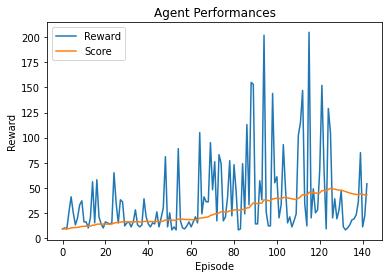

In [54]:
""" Plot reward & score """

import matplotlib.pyplot as plt

y1 = scores
y2 = epRewards
x  = list(range(len(y1)))
plt.plot(x, y2, label="Reward")
plt.plot(x, y1, label="Score")
plt.plot()

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Agent Performances")
plt.legend()
plt.show()

In [55]:
""" Display the transitions of an episode """

state = env.reset()
action = None
while True :
  previousAction = action
  action = doer.act(state)
  previousState = state
  state, reward, done, info = env.step(action)
  transition = Transition(previousState, previousAction, reward, state, action, isTerminal=done, birthdate=_)
  print(f"transition + qValues : {transition} \t\t{doer.qNetwork.Q([previousState])}")
  if done : break

transition + qValues : [Transition] St: [ 0.00534831 -0.02750229 -0.02574055 -0.0021304 ] | At: None | Rt: 1.0 | St+1: [ 0.00479827  0.16797918 -0.02578315 -0.30282236] | At+1: 1 | isTerminal: False | ID: None | relevance: None | birthdate: 99 		tensor([[0.8713, 0.8777]], grad_fn=<PermuteBackward>)
transition + qValues : [Transition] St: [ 0.00479827  0.16797918 -0.02578315 -0.30282236] | At: 1 | Rt: 1.0 | St+1: [ 0.00815785  0.36345892 -0.0318396  -0.60352392] | At+1: 1 | isTerminal: False | ID: None | relevance: None | birthdate: 99 		tensor([[0.8707, 0.8774]], grad_fn=<PermuteBackward>)
transition + qValues : [Transition] St: [ 0.00815785  0.36345892 -0.0318396  -0.60352392] | At: 1 | Rt: 1.0 | St+1: [ 0.01542703  0.16879641 -0.04391008 -0.32103741] | At+1: 0 | isTerminal: False | ID: None | relevance: None | birthdate: 99 		tensor([[0.8753, 0.8745]], grad_fn=<PermuteBackward>)
transition + qValues : [Transition] St: [ 0.01542703  0.16879641 -0.04391008 -0.32103741] | At: 0 | Rt: 1.

# Renderer

Source : https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=odNaDE1zyrL2

In [24]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [25]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 788kB 22.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2


In [26]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [28]:
_env = gym.make("CartPole-v1")
_env.seed(2)
env_wrapped = wrap_env(_env)
print(env_wrapped.action_space)

observation = env_wrapped.reset()

while True:
  
    env_wrapped.render()
    
    action = doer.act(observation)
    print(action)
    observation, reward, done, info = env_wrapped.step(action) 

    if done: 
      break;
            
env_wrapped.close()
show_video()

Discrete(2)
1
1
1
1
0
0
0
0
0
1
1
0
1
0
0
1
0
1
0
0
1
0
1
0
1
1
1
0
1
0
0
0
1
0
